In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from scipy.stats import skew, kurtosis
from scipy.stats import pearsonr
from scipy.stats import norm
from scipy.optimize import minimize

### 1. Stock Returns Analysis – Descriptive Analytics

Step 1A – Read & Inspect Adjusted Close Data

In [2]:
# List of tickers and filenames
files = {
    'JPM': 'jpm.csv',
    'BAC': 'bac.csv',
    'WFC': 'wfc.csv',
    'GS':  'gs.csv',
    'BLK': 'blk.csv',
    'PLD': 'pld.csv',
    'AMT': 'amt.csv',
    'SPG': 'spg.csv',
    'AVB': 'avb.csv',
    'O':   'o.csv'
}

# Read and preview the top 3 rows from each file
for ticker, filename in files.items():
    df = pd.read_csv(f"./data/{filename}", parse_dates=['Date'], index_col='Date')
    print(f"\n=== {ticker} ===")
    print(df.head(3))
    print("Columns:", df.columns.tolist())


=== JPM ===
           Close/Last    Volume     Open       High      Low
Date                                                        
2025-10-17    $297.56  10153450  $299.16    $299.55  $294.20
2025-10-16    $298.54  10549450  $305.35  $308.6799  $297.07
2025-10-15    $305.69  11354780  $306.39  $312.1199  $305.44
Columns: ['Close/Last', 'Volume', 'Open', 'High', 'Low']

=== BAC ===
           Close/Last    Volume    Open     High     Low
Date                                                    
2025-10-17     $51.28  48915380  $50.95   $51.77  $50.33
2025-10-16     $50.44  49027710  $52.60  $52.755  $50.00
2025-10-15     $52.28  69992190  $51.57   $52.85  $51.23
Columns: ['Close/Last', 'Volume', 'Open', 'High', 'Low']

=== WFC ===
           Close/Last    Volume     Open     High     Low
Date                                                     
2025-10-17     $83.28  18798990   $84.45  $84.525  $82.31
2025-10-16     $84.00  22715620   $86.99   $87.43  $83.00
2025-10-15     $86.46  22

Step 1B – Clean and Standardize Price Data

In [3]:
files = {
    'JPM': 'jpm.csv', 'BAC': 'bac.csv', 'WFC': 'wfc.csv',
    'GS': 'gs.csv', 'BLK': 'blk.csv', 'PLD': 'pld.csv',
    'AMT': 'amt.csv', 'SPG': 'spg.csv', 'AVB': 'avb.csv', 'O': 'o.csv'
}

cleaned = {}

for ticker, filename in files.items():
    df = pd.read_csv(f"./data/{filename}")
    df.columns = df.columns.str.strip()   # remove hidden/trailing spaces
    df['Date'] = pd.to_datetime(df['Date'])

    # find the column containing 'Close'
    close_col = [c for c in df.columns if 'Close' in c][0]

    # clean $ and convert to float
    df[ticker] = df[close_col].replace(r'[\$,]', '', regex=True).astype(float)

    # keep only Date + ticker column
    df = df[['Date', ticker]].sort_values('Date').reset_index(drop=True)
    cleaned[ticker] = df

    print(f"{ticker}: {len(df)} rows, from {df['Date'].min().date()} to {df['Date'].max().date()}")

# quick preview
display(cleaned['JPM'].head())



JPM: 1256 rows, from 2020-10-19 to 2025-10-17
BAC: 1256 rows, from 2020-10-19 to 2025-10-17
WFC: 1256 rows, from 2020-10-19 to 2025-10-17
GS: 1256 rows, from 2020-10-19 to 2025-10-17
BLK: 1256 rows, from 2020-10-19 to 2025-10-17
PLD: 1256 rows, from 2020-10-19 to 2025-10-17
AMT: 1256 rows, from 2020-10-19 to 2025-10-17
SPG: 1256 rows, from 2020-10-19 to 2025-10-17
AVB: 1256 rows, from 2020-10-19 to 2025-10-17
O: 1256 rows, from 2020-10-19 to 2025-10-17


,Date,JPM
0,2020-10-19,99.80
1,2020-10-20,100.37
2,2020-10-21,99.37
3,2020-10-22,102.88
4,2020-10-23,103.81


Step 1C – Merge Prices & Compute Weekly Log Returns

In [4]:
# --- Merge all 10 tickers by Date ---
merged_prices = cleaned['JPM']
for t in [k for k in cleaned.keys() if k != 'JPM']:
    merged_prices = pd.merge(merged_prices, cleaned[t], on='Date', how='inner')

# --- Set Date as index for resampling ---
merged_prices = merged_prices.set_index('Date').sort_index()

# --- Resample to weekly frequency (Friday closing) ---
weekly_prices = merged_prices.resample('W-FRI').last()

# --- Compute log returns ---
weekly_returns = np.log(weekly_prices / weekly_prices.shift(1))

# --- Drop the first NaN row ---
weekly_returns = weekly_returns.dropna()

# --- Save files for Step 2 ---
weekly_prices.to_csv('./output/step1_prices.csv', index=True)
weekly_returns.to_csv('./output/step1_returns.csv', index=True)

print("✅ Weekly log returns computed successfully!")
print("Rows:", len(weekly_returns))
print("Date range:", weekly_returns.index.min().date(), "to", weekly_returns.index.max().date())
weekly_returns.head()

✅ Weekly log returns computed successfully!
Rows: 260
Date range: 2020-10-30 to 2025-10-17


,JPM,BAC,WFC,GS,BLK,PLD,AMT,SPG,AVB,O
Date,,,,,,,,,,
2020-10-30,-0.057187,-0.049393,-0.081870,-0.081246,-0.061644,-0.039918,-0.034537,-0.062786,-0.046758,-0.048740
2020-11-06,0.048965,0.025413,0.021219,0.062639,0.088870,0.055774,0.053001,-0.015241,0.061466,0.002243
2020-11-13,0.102559,0.104949,0.094023,0.084839,0.022452,-0.013051,0.003874,0.188606,0.135034,0.083658
2020-11-20,0.004286,-0.007062,0.056928,0.019303,0.004380,-0.031995,-0.043854,0.082449,0.015004,-0.043105
2020-11-27,0.056421,0.078176,0.110606,0.052546,0.061122,0.003286,0.006127,0.053171,-0.023723,0.020488


Step 1D – Descriptive Statistics of Weekly Returns

In [5]:
# Compute descriptive stats
stats_df = pd.DataFrame({
    'Mean': weekly_returns.mean(),
    'Median': weekly_returns.median(),
    'StdDev': weekly_returns.std(),
    'Skewness': weekly_returns.apply(skew),
    'Kurtosis': weekly_returns.apply(kurtosis)
})

# Round neatly for readability
stats_df = stats_df.round(4)

# Save to Excel
stats_df.to_excel('./output/Step1_Returns.xlsx')

print("✅ Descriptive statistics saved as ./output/Step1_Returns.xlsx")
stats_df

✅ Descriptive statistics saved as ./output/Step1_Returns.xlsx


,Mean,Median,StdDev,Skewness,Kurtosis
JPM,0.0041,0.0064,0.0359,-0.2812,1.4033
BAC,0.0028,0.0069,0.0413,-0.4461,1.5747
WFC,0.0049,0.0046,0.0450,-0.3231,0.7536
GS,0.0050,0.0036,0.0406,-0.1100,0.8485
BLK,0.0023,0.0037,0.0387,0.2088,1.6726
PLD,0.0007,0.0042,0.0391,-0.3784,1.4013
AMT,-0.0008,-0.0010,0.0375,0.1663,0.0680
SPG,0.0038,0.0033,0.0403,0.4535,2.1311
AVB,0.0010,0.0017,0.0308,-0.0143,1.7356
O,0.0000,-0.0006,0.0256,0.1023,0.2108


Step 1E – Visualizing Return Distributions

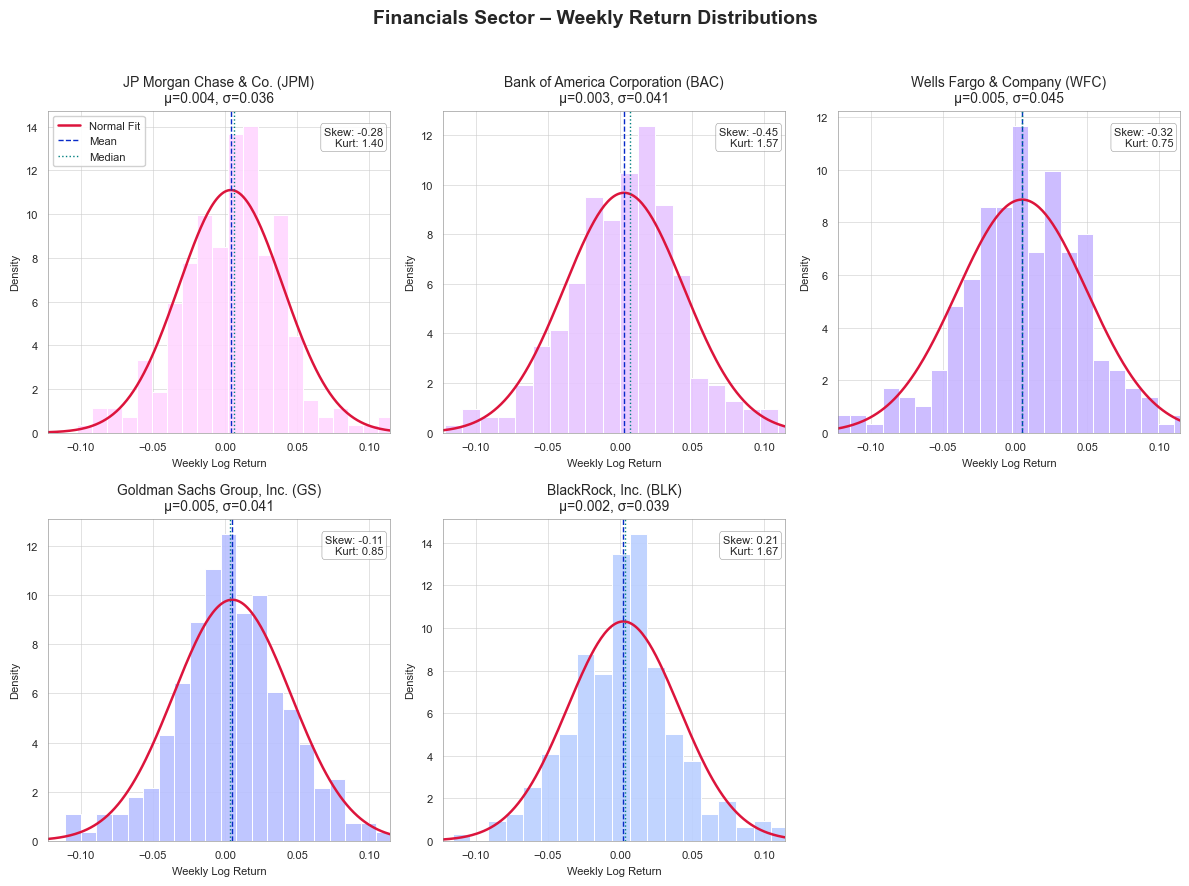

✅ Saved: ./output/financials_histograms.png


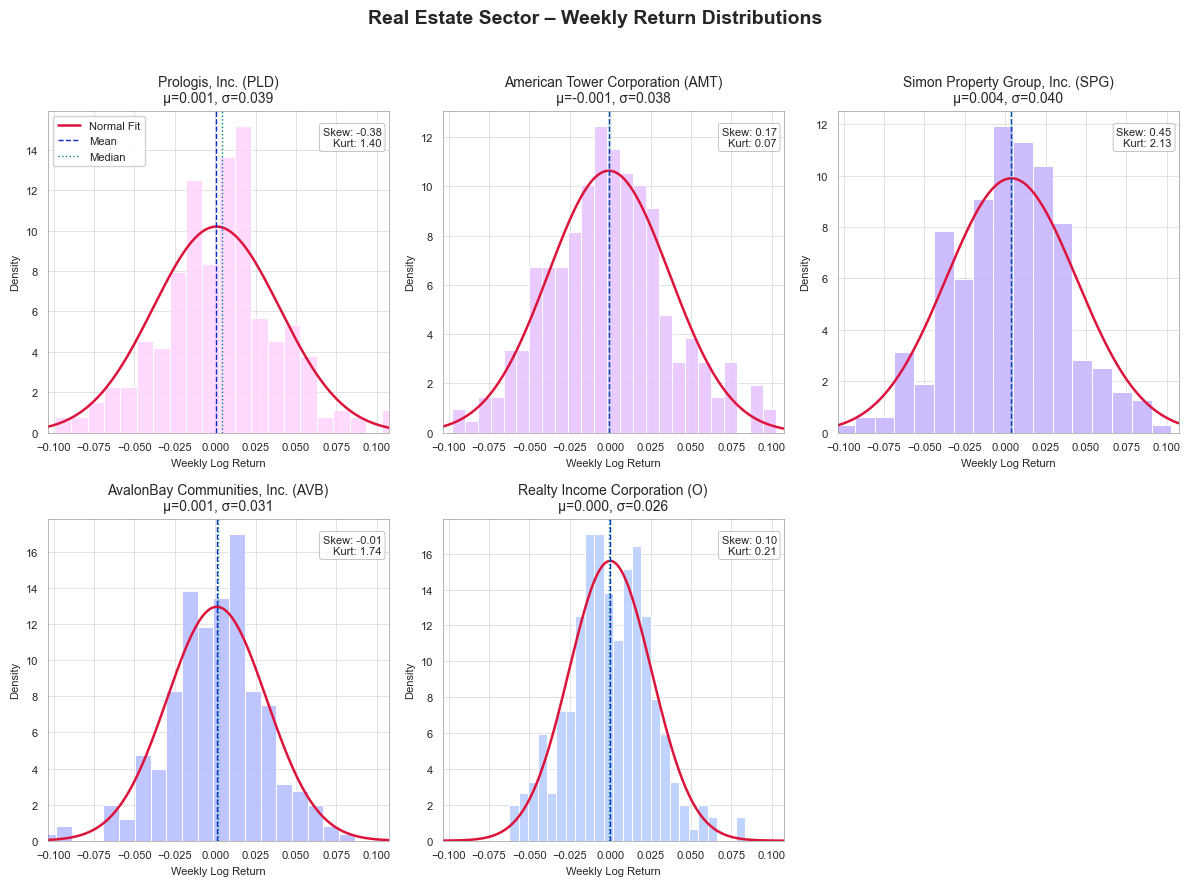

✅ Saved: ./output/realestate_histograms.png


In [6]:
# --- Sector groupings with full names ---
financials = {
    'JPM': 'JP Morgan Chase & Co. (JPM)',
    'BAC': 'Bank of America Corporation (BAC)',
    'WFC': 'Wells Fargo & Company (WFC)',
    'GS':  'Goldman Sachs Group, Inc. (GS)',
    'BLK': 'BlackRock, Inc. (BLK)'
}

real_estate = {
    'PLD': 'Prologis, Inc. (PLD)',
    'AMT': 'American Tower Corporation (AMT)',
    'SPG': 'Simon Property Group, Inc. (SPG)',
    'AVB': 'AvalonBay Communities, Inc. (AVB)',
    'O':   'Realty Income Corporation (O)'
}

# --- Pastel palette ---
pastel_colors = ['#FFD6FF', '#E7C6FF', '#C8B6FF', '#B8C0FF', '#BBD0FF', '#C0E0FF']

# --- Style tweaks ---
sns.set_style("whitegrid")
plt.rcParams.update({
    "axes.grid": True,
    "grid.linewidth": 0.4,
    "axes.labelsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "axes.titlesize": 10,
    "legend.fontsize": 8
})

def plot_sector_histograms(ticker_dict, sector_name, filename):
    tickers = list(ticker_dict.keys())
    names = list(ticker_dict.values())

    # Compute common x-limits across all tickers in the sector
    all_data = np.concatenate([weekly_returns[t].dropna().values for t in tickers])
    x_min, x_max = np.percentile(all_data, [0.5, 99.5])  # clip outliers gently

    fig, axes = plt.subplots(2, 3, figsize=(12, 9))
    axes = axes.flatten()

    for i, (ticker, title) in enumerate(zip(tickers, names)):
        ax = axes[i]
        data = weekly_returns[ticker].dropna()
        color = pastel_colors[i % len(pastel_colors)]

        sns.histplot(data, bins=25, stat='density',
                     color=color, edgecolor='white', ax=ax, alpha=0.9)

        mu, sigma = data.mean(), data.std()
        x = np.linspace(x_min, x_max, 200)
        y = norm.pdf(x, mu, sigma)
        ax.plot(x, y, color='crimson', lw=1.8, label='Normal Fit')

        # Mean & Median lines
        ax.axvline(mu, color='#072AC8', linestyle='--', lw=1.0, label='Mean')
        ax.axvline(data.median(), color='teal', linestyle=':', lw=1.0, label='Median')

        # Annotation
        skew_val = skew(data)
        kurt_val = kurtosis(data)
        ax.text(0.98, 0.95, f"Skew: {skew_val:.2f}\nKurt: {kurt_val:.2f}",
                transform=ax.transAxes, fontsize=8, ha='right', va='top',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=0.4, alpha=0.8))

        # Aesthetic cleanup
        ax.set_xlim(x_min, x_max)
        ax.set_title(f"{title}\nμ={mu:.3f}, σ={sigma:.3f}", fontsize=10, pad=6)
        ax.set_xlabel("Weekly Log Return")
        ax.set_ylabel("Density")

        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.4)
            spine.set_color("gray")

        if i == 0:
            ax.legend(loc='upper left', frameon=True, framealpha=0.9)

    # Remove extra subplot (6th blank cell)
    for j in range(len(tickers), len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(f"{sector_name} Sector – Weekly Return Distributions",
                 fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Saved: {filename}")

# --- Generate plots ---
plot_sector_histograms(financials, "Financials", "./output/financials_histograms.png")
plot_sector_histograms(real_estate, "Real Estate", "./output/realestate_histograms.png")

### 2. Covariance and Correlation Analysis

Step 2A — Align and Merge Datasets (Weekly Frequency Sync)

In [7]:
# 1️⃣ Load stock returns
returns = pd.read_csv("./output/step1_returns.csv", parse_dates=["Date"], index_col="Date")

# 2️⃣ Load S&P 500 with explicit 2-digit year format (MM/DD/YY)
sp500 = pd.read_csv(
    "./data/sp500.csv",
    parse_dates=["Date"],
    date_format="%m/%d/%y",   # ✅ modern replacement for date_parser
    index_col="Date"
)

# 3️⃣ Keep only Close column and rename
sp500 = sp500[["Close"]].rename(columns={"Close": "SP500"})

# 4️⃣ Compute weekly log returns
sp500["SP500_ret"] = np.log(sp500["SP500"] / sp500["SP500"].shift(1))
sp500 = sp500.dropna(subset=["SP500_ret"])

# 5️⃣ Align datasets by Date (intersection)
merged = returns.join(sp500["SP500_ret"], how="inner")

# 6️⃣ Verify
print("Merged shape:", merged.shape)
print("Date range:", merged.index.min(), "to", merged.index.max())
print("\nColumns:", merged.columns.tolist())
print("\nSample:\n", merged.head())

Merged shape: (251, 11)
Date range: 2020-10-30 00:00:00 to 2025-10-17 00:00:00

Columns: ['JPM', 'BAC', 'WFC', 'GS', 'BLK', 'PLD', 'AMT', 'SPG', 'AVB', 'O', 'SP500_ret']

Sample:
                  JPM       BAC       WFC        GS       BLK       PLD  \
Date                                                                     
2020-10-30 -0.057187 -0.049393 -0.081870 -0.081246 -0.061644 -0.039918   
2020-11-06  0.048965  0.025413  0.021219  0.062639  0.088870  0.055774   
2020-11-13  0.102559  0.104949  0.094023  0.084839  0.022452 -0.013051   
2020-11-20  0.004286 -0.007062  0.056928  0.019303  0.004380 -0.031995   
2020-11-27  0.056421  0.078176  0.110606  0.052546  0.061122  0.003286   

                 AMT       SPG       AVB         O  SP500_ret  
Date                                                           
2020-10-30 -0.034537 -0.062786 -0.046758 -0.048740  -0.012204  
2020-11-06  0.053001 -0.015241  0.061466  0.002243  -0.000288  
2020-11-13  0.003874  0.188606  0.135034  0.0

Step 2B — Compute Covariance and Correlation Matrices

In [8]:
# 1️⃣ Compute the variance-covariance matrix
cov_matrix = merged.cov()

# 2️⃣ Compute the correlation matrix
corr_matrix = merged.corr()

# 3️⃣ Display basic info
print("Covariance Matrix (first 5 rows):\n", cov_matrix.head(), "\n")
print("Correlation Matrix (first 5 rows):\n", corr_matrix.head())
with pd.ExcelWriter("./output/step2_correlation.xlsx") as writer:
    cov_matrix.to_excel(writer, sheet_name="Covariance_Matrix")
    corr_matrix.to_excel(writer, sheet_name="Correlation_Matrix")

print("✅ ./output/step2_correlation.xlsx created successfully.")

Covariance Matrix (first 5 rows):
           JPM       BAC       WFC        GS       BLK       PLD       AMT  \
JPM  0.001306  0.001305  0.001294  0.001251  0.000940  0.000489  0.000249   
BAC  0.001305  0.001727  0.001591  0.001428  0.001056  0.000602  0.000266   
WFC  0.001294  0.001591  0.002070  0.001418  0.000978  0.000514  0.000172   
GS   0.001251  0.001428  0.001418  0.001684  0.001149  0.000653  0.000377   
BLK  0.000940  0.001056  0.000978  0.001149  0.001525  0.000941  0.000664   

          SPG       AVB         O  SP500_ret  
JPM  0.000911  0.000521  0.000289   0.000185  
BAC  0.001108  0.000622  0.000349   0.000206  
WFC  0.001038  0.000612  0.000324   0.000193  
GS   0.001078  0.000636  0.000414   0.000204  
BLK  0.000887  0.000597  0.000498   0.000228   

Correlation Matrix (first 5 rows):
           JPM       BAC       WFC        GS       BLK       PLD       AMT  \
JPM  1.000000  0.869198  0.786802  0.843605  0.666407  0.342978  0.181656   
BAC  0.869198  1.000000  0.8

Step 2C — Compare Intra-Sector vs Cross-Sector Correlations

In [9]:
# Define sector groups
financials = ["JPM", "BAC", "WFC", "GS", "BLK"]
real_estate = ["PLD", "AMT", "SPG", "AVB", "O"]

# Extract correlation submatrices
corr_financials = corr_matrix.loc[financials, financials]
corr_realestate = corr_matrix.loc[real_estate, real_estate]
corr_cross = corr_matrix.loc[financials, real_estate]

# Compute mean correlations (excluding self-correlations)
intra_fin = corr_financials.where(~np.eye(len(corr_financials),dtype=bool)).stack().mean()
intra_re = corr_realestate.where(~np.eye(len(corr_realestate),dtype=bool)).stack().mean()
cross_sector = corr_cross.stack().mean()

# Correlation with S&P500
corr_with_sp500 = corr_matrix["SP500_ret"].drop("SP500_ret")

print(f"Average Intra-Financial Correlation: {intra_fin:.3f}")
print(f"Average Intra-RealEstate Correlation: {intra_re:.3f}")
print(f"Average Cross-Sector Correlation: {cross_sector:.3f}")
print("\nCorrelation with S&P500:")
print(corr_with_sp500.sort_values(ascending=False))

Average Intra-Financial Correlation: 0.752
Average Intra-RealEstate Correlation: 0.538
Average Cross-Sector Correlation: 0.414

Correlation with S&P500:
BLK    0.505022
JPM    0.442740
AVB    0.439276
GS     0.428989
BAC    0.427336
O      0.391149
PLD    0.377570
SPG    0.366729
WFC    0.365631
AMT    0.274365
Name: SP500_ret, dtype: float64


Step 2D — Visualize Correlation Structure (Heatmap)

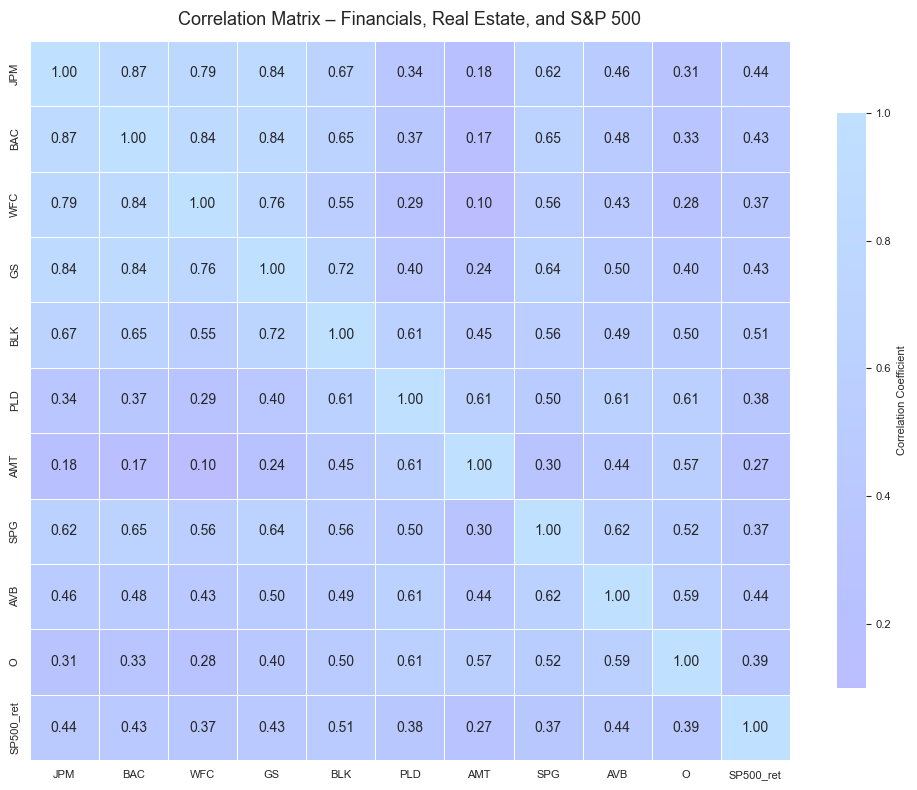

In [10]:
# 1️⃣ Define your custom pastel palette
pastel_colors = ['#FFD6FF', '#E7C6FF', '#C8B6FF', '#B8C0FF', '#BBD0FF', '#C0E0FF']
pastel_cmap = LinearSegmentedColormap.from_list("pastel_cmap", pastel_colors, N=256)

# 2️⃣ Set up the figure
plt.figure(figsize=(10, 8))

# 3️⃣ Draw the heatmap
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap=pastel_cmap,
    center=0,
    linewidths=0.4,
    cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"}
)

# 4️⃣ Title and layout
plt.title("Correlation Matrix – Financials, Real Estate, and S&P 500", fontsize=13, pad=12)
plt.tight_layout()

# 5️⃣ Save figure
plt.savefig("./output/step2_correlation_heatmap_pastel.png", dpi=300)
plt.show()

### 3. Stock Returns and Financial Fundamentals Relationship Analysis

Step 3A – Load and Prepare the Datasets

In [11]:
# 1️⃣ Load files
returns_df = pd.read_csv("./output/step1_returns.csv")
fund_df = pd.read_csv("./data/capiq.csv")

# 2️⃣ Reshape returns (wide → long)
returns_long = returns_df.melt(
    id_vars="Date",
    var_name="Ticker",
    value_name="Daily_Return"
)
print(returns_long.head())

# 3️⃣ Compute avg return & volatility
perf_df = (
    returns_long.groupby("Ticker")["Daily_Return"]
    .agg(avg_return="mean", volatility="std")
    .reset_index()
)
print(perf_df)

# 4️⃣ Extract ticker from 'Entity Name' column
fund_df["Ticker"] = fund_df["SP_ENTITY_NAME"].str.extract(r'\(NYSE:(.*?)\)')
fund_df["Ticker"] = fund_df["Ticker"].str.strip()

# 5️⃣ Detect numeric fundamentals & drop identifier columns
num_cols = fund_df.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ["SP_ENTITY_ID"]
num_cols = [c for c in num_cols if c not in exclude_cols]
print("Updated fundamentals analyzed:", num_cols)

# 6️⃣ Merge on ticker
merged_df = pd.merge(fund_df, perf_df, on="Ticker", how="inner")
print(merged_df.head())
print("Merged dataset shape:", merged_df.shape)
print("Tickers merged:", merged_df["Ticker"].tolist())


         Date Ticker  Daily_Return
0  2020-10-30    JPM     -0.057187
1  2020-11-06    JPM      0.048965
2  2020-11-13    JPM      0.102559
3  2020-11-20    JPM      0.004286
4  2020-11-27    JPM      0.056421
  Ticker  avg_return  volatility
0    AMT   -0.000836    0.037519
1    AVB    0.000958    0.030773
2    BAC    0.002779    0.041273
3    BLK    0.002307    0.038705
4     GS    0.004992    0.040629
5    JPM    0.004050    0.035930
6      O    0.000022    0.025575
7    PLD    0.000707    0.039098
8    SPG    0.003767    0.040329
9    WFC    0.004902    0.044993
Updated fundamentals analyzed: ['SP_ROE', 'SNL_GROSS_MARGIN', 'SNL_NET_MARGIN', 'IQ_EBITDA_MARGIN', 'IQ_DEBT_TO_EQUITY', 'IQ_PE', 'SNL_DIV_YLD_PAID_REGULAR', 'IQ_ROA', 'IQ_EBIT_INT']
                           SP_ENTITY_NAME  SP_ENTITY_ID SP_MARKETCAP  \
0   American Tower Corporation (NYSE:AMT)       4290489    89,108.21   
1  AvalonBay Communities, Inc. (NYSE:AVB)        103145    26,883.18   
2  Bank of America Corporati

Step 3B – Compute Pairwise Correlations and Trend Statistics

In [12]:
corr_summary = []
for col in num_cols:
    r_return = merged_df["avg_return"].corr(merged_df[col])
    r_vol = merged_df["volatility"].corr(merged_df[col])
    corr_summary.append({
        "Fundamental": col.strip(),
        "Corr_with_Return": round(r_return, 3),
        "Corr_with_Volatility": round(r_vol, 3)
    })

corr_table = pd.DataFrame(corr_summary)
corr_table.sort_values("Corr_with_Return", ascending=False, inplace=True)
print(corr_table)

                Fundamental  Corr_with_Return  Corr_with_Volatility
4         IQ_DEBT_TO_EQUITY             0.566                 0.550
8               IQ_EBIT_INT             0.369                 0.348
0                    SP_ROE             0.248                 0.262
3          IQ_EBITDA_MARGIN            -0.264                -0.506
7                    IQ_ROA            -0.388                -0.126
6  SNL_DIV_YLD_PAID_REGULAR            -0.522                -0.588
5                     IQ_PE            -0.851                -0.508
1          SNL_GROSS_MARGIN               NaN                   NaN
2            SNL_NET_MARGIN               NaN                   NaN


Step 3C – Scatterplots and Trendlines

Avg return range: -0.0008357804205149843 to 0.004991901017228549
Volatility range: 0.025574562073703497 to 0.04499317778802768
Y-scales: {'avg_return': (-0.0017099326361765142, 0.005866053232890079), 'volatility': (-0.0029127923571486275, 0.04790597014517631)}


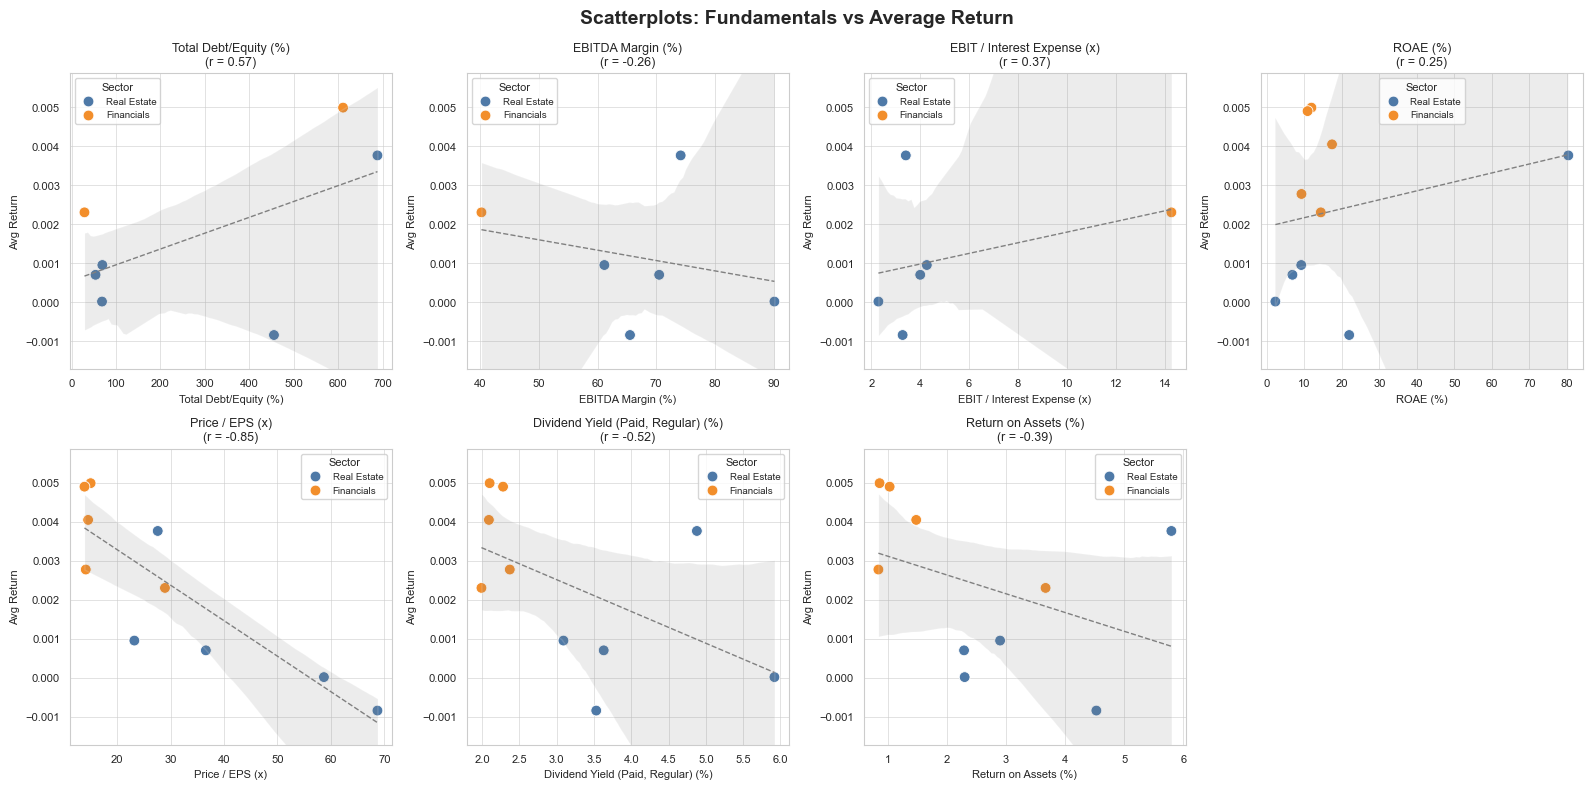

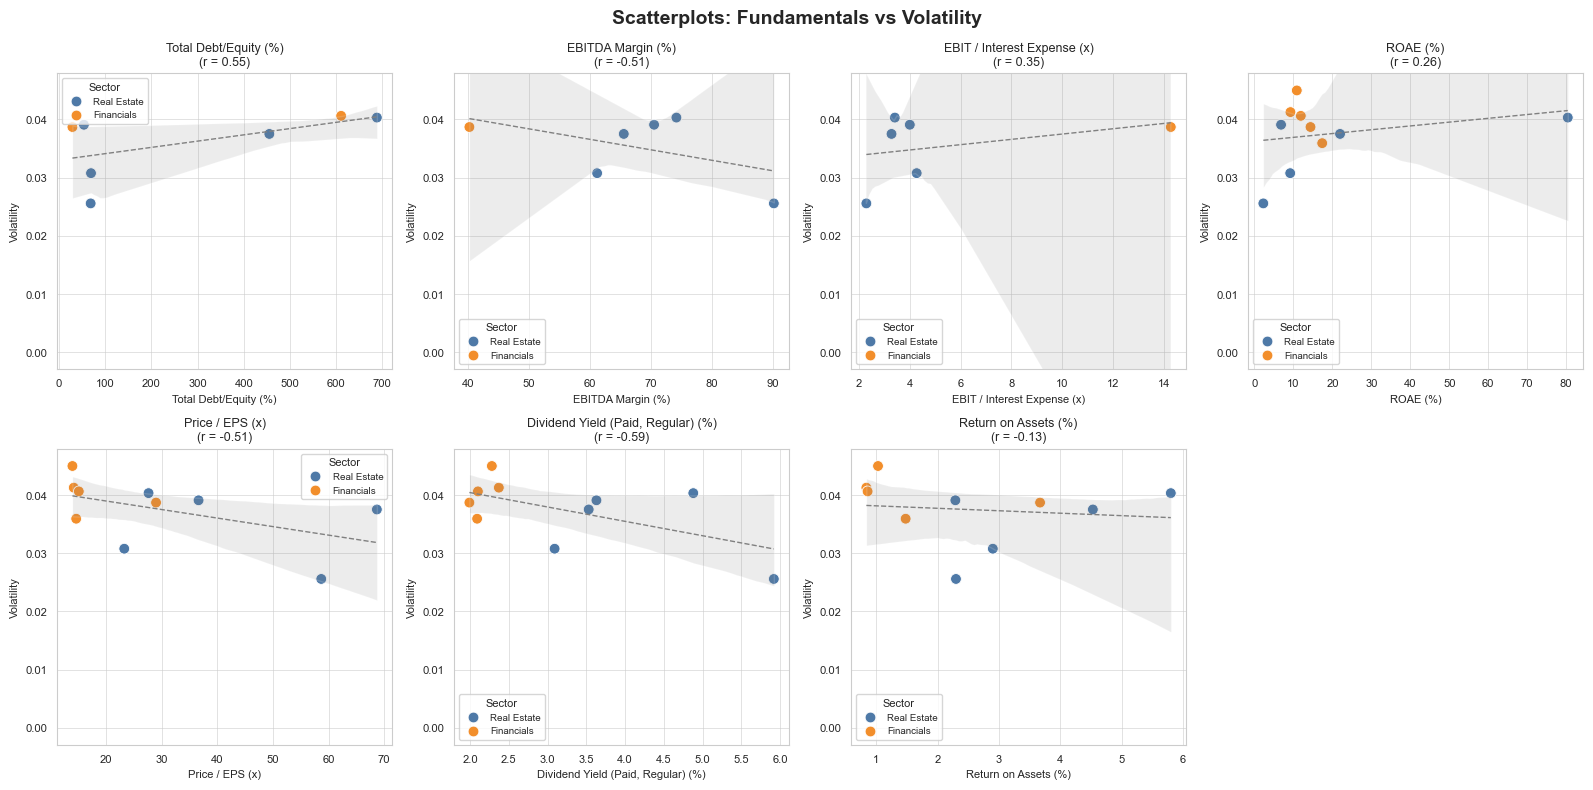

✅ Negative/zero Y-range enforced and full data retained.


In [13]:
# --- Sector grouping (re-map each ticker) ---
sector_map = {
    'JPM': 'Financials', 'BAC': 'Financials', 'WFC': 'Financials',
    'GS': 'Financials', 'BLK': 'Financials',
    'PLD': 'Real Estate', 'AMT': 'Real Estate', 'SPG': 'Real Estate',
    'AVB': 'Real Estate', 'O': 'Real Estate'
}
merged_df['Sector'] = merged_df['Ticker'].map(sector_map)

sns.set_style("whitegrid")
plt.rcParams.update({"font.size": 9})

label_map = {
    'SP_MARKETCAP': "Market Capitalization ($M)",
    'SP_TOTAL_REV': "Total Revenue ($000)",
    'SP_ROE': "ROAE (%)",
    'SNL_GROSS_MARGIN': "Gross Margin (%)",
    'SNL_NET_MARGIN': "Net Margin (%)",
    'IQ_EBITDA_MARGIN': "EBITDA Margin (%)",
    'IQ_DEBT_TO_EQUITY': "Total Debt/Equity (%)",
    'IQ_TOTAL_DEBT': "Total Debt ($000)",
    'IQ_TOTAL_ASSETS': "Total Assets ($000)",
    'IQ_PE': "Price / EPS (x)",
    'SNL_DIV_YLD_PAID_REGULAR': "Dividend Yield (Paid, Regular) (%)",
    'IQ_ROA': "Return on Assets (%)",
    'IQ_EBIT_INT': "EBIT / Interest Expense (x)"
}

fundamental_vars = [
    'IQ_DEBT_TO_EQUITY', 'IQ_EBITDA_MARGIN', 'IQ_EBIT_INT',
    'SP_ROE', 'IQ_PE', 'SNL_DIV_YLD_PAID_REGULAR', 'IQ_ROA'
]

palette = {"Financials": "#f28e2b", "Real Estate": "#4e79a7"}

# --- Check actual value ranges ---
print("Avg return range:", merged_df["avg_return"].min(), "to", merged_df["avg_return"].max())
print("Volatility range:", merged_df["volatility"].min(), "to", merged_df["volatility"].max())

# --- Global Y-scale (always include negative buffer) ---
def y_limits(series):
    lo, hi = series.min(), series.max()
    # expand range symmetrically and force small negative if all positive
    pad = (hi - lo) * 0.15 if hi != lo else abs(lo) * 0.1 + 0.001
    lo_adj = lo - pad
    if lo_adj > 0:
        lo_adj = -pad  # ensure visible negative zone
    hi_adj = hi + pad
    return lo_adj, hi_adj

y_scales = {
    "avg_return": y_limits(merged_df["avg_return"]),
    "volatility": y_limits(merged_df["volatility"])
}
print("Y-scales:", y_scales)

def scatter_sector(ax, x, y, data):
    subset = data.loc[data[x].notna() & data[y].notna(), [x, y, "Sector"]]
    r = np.nan
    if len(subset) > 1 and subset[x].nunique() > 1 and subset[y].nunique() > 1:
        r, _ = pearsonr(subset[x], subset[y])

    sns.scatterplot(
        data=subset, x=x, y=y, hue="Sector", palette=palette,
        s=60, edgecolor="white", linewidth=0.6, ax=ax
    )
    sns.regplot(
        data=subset, x=x, y=y, scatter=False, ax=ax,
        color="gray", line_kws={"linestyle": "--", "linewidth": 1}
    )

    ax.set_title(f"{label_map.get(x, x)}\n(r = {r:.2f})", fontsize=9)
    ax.set_xlabel(label_map.get(x, x), fontsize=8)
    ax.set_ylabel("Avg Return" if y == "avg_return" else "Volatility", fontsize=8)
    ax.legend(title="Sector", loc="best", fontsize=7, title_fontsize=8)
    ax.set_ylim(y_scales[y])  # Apply stable global scale

# === 1. Fundamentals vs Average Return ===
fig1, axes1 = plt.subplots(2, 4, figsize=(16, 8))
valid_vars = [v for v in fundamental_vars if v in merged_df.columns]

for i, var in enumerate(valid_vars):
    row, col = divmod(i, 4)
    scatter_sector(axes1[row, col], var, "avg_return", merged_df)
for j in range(len(valid_vars), 8):
    fig1.delaxes(axes1.flatten()[j])
fig1.suptitle("Scatterplots: Fundamentals vs Average Return", fontsize=14, weight='bold')
plt.tight_layout()
fig1.subplots_adjust(top=0.90)
plt.show()
fig1.savefig("./output/scatter_avgreturn_grid.png", dpi=300)

# === 2. Fundamentals vs Volatility ===
fig2, axes2 = plt.subplots(2, 4, figsize=(16, 8))
for i, var in enumerate(valid_vars):
    row, col = divmod(i, 4)
    scatter_sector(axes2[row, col], var, "volatility", merged_df)
for j in range(len(valid_vars), 8):
    fig2.delaxes(axes2.flatten()[j])
fig2.suptitle("Scatterplots: Fundamentals vs Volatility", fontsize=14, weight='bold')
plt.tight_layout()
fig2.subplots_adjust(top=0.90)
plt.show()
fig2.savefig("./output/scatter_volatility_grid.png", dpi=300)

print("✅ Negative/zero Y-range enforced and full data retained.")

### 4. Equal-weighted Portfolio Construction & Performance Analysis

Step 4A – Load and Preview Data

In [14]:
# step1_returns.csv already uses ISO dates like 2020-10-30
returns = pd.read_csv("./output/step1_returns.csv", parse_dates=['Date'])
sp500 = pd.read_csv("./data/sp500.csv", parse_dates=['Date'], date_format="%m/%d/%y")
tbill = pd.read_csv("./data/13w_tbill.csv", parse_dates=['Date'], date_format="%m/%d/%y")


# --- 2. Keep only relevant columns ---
sp500 = sp500[['Date', 'Close']].rename(columns={'Close': 'SP500_Close'})
tbill = tbill[['Date', 'Close']].rename(columns={'Close': 'TBILL_Yield'})

# --- 3. Convert S&P 500 daily price → weekly log returns ---
sp500 = sp500.sort_values('Date').set_index('Date')
sp500 = sp500.resample('W-FRI').last()  # last trading day each week
sp500['SP500_ret'] = np.log(sp500['SP500_Close'] / sp500['SP500_Close'].shift(1))
sp500 = sp500.dropna(subset=['SP500_ret']).reset_index()

# --- 4. Convert T-bill daily yield → weekly average yield (still annualized %) ---
tbill = tbill.sort_values('Date').set_index('Date')
tbill = tbill.resample('W-FRI').mean().reset_index()

# --- 5. Trim step1_returns to same weekly Fridays ---
returns = returns.sort_values('Date')
returns['Date'] = pd.to_datetime(returns['Date'])
returns = returns.set_index('Date').resample('W-FRI').last().reset_index()

# --- 6. Verify alignment ---
common_start = max(returns['Date'].min(), sp500['Date'].min(), tbill['Date'].min())
common_end   = min(returns['Date'].max(), sp500['Date'].max(), tbill['Date'].max())

print(f"\nCommon date range: {common_start.date()} to {common_end.date()}")

# --- 7. Merge date lists for alignment check ---
merged_dates = (
    returns[['Date']]
    .merge(sp500[['Date']], on='Date')
    .merge(tbill[['Date']], on='Date')
)
print(f"Aligned weekly observations: {len(merged_dates)}")

# --- 8. Show previews ---
print("\n--- step1_returns.csv (weekly returns) ---")
print(returns.head(3))
print("\n--- sp500.csv (weekly derived returns) ---")
print(sp500[['Date','SP500_ret']].head(3))
print("\n--- 13w_tbill.csv (weekly avg yield, annualized %) ---")
print(tbill.head(3))


Common date range: 2020-11-06 to 2025-10-17
Aligned weekly observations: 259

--- step1_returns.csv (weekly returns) ---
        Date       JPM       BAC       WFC        GS       BLK       PLD  \
0 2020-10-30 -0.057187 -0.049393 -0.081870 -0.081246 -0.061644 -0.039918   
1 2020-11-06  0.048965  0.025413  0.021219  0.062639  0.088870  0.055774   
2 2020-11-13  0.102559  0.104949  0.094023  0.084839  0.022452 -0.013051   

        AMT       SPG       AVB         O  
0 -0.034537 -0.062786 -0.046758 -0.048740  
1  0.053001 -0.015241  0.061466  0.002243  
2  0.003874  0.188606  0.135034  0.083658  

--- sp500.csv (weekly derived returns) ---
        Date  SP500_ret
0 2020-11-06   0.070679
1 2020-11-13   0.021344
2 2020-11-20  -0.007731

--- 13w_tbill.csv (weekly avg yield, annualized %) ---
        Date  TBILL_Yield
0 2020-10-23       0.0886
1 2020-10-30       0.0852
2 2020-11-06       0.0848


Step 4B – Convert 13W Treasury Yield (annualized %) to Weekly Risk-Free Rate

In [15]:
# Copy the TBILL_Yield column to preserve original
tbill['RF_weekly'] = ((1 + tbill['TBILL_Yield'] / 100) ** (1/52)) - 1

# Preview the conversion
print("\n--- Risk-free weekly rate sample ---")
print(tbill[['Date', 'TBILL_Yield', 'RF_weekly']].head(5))

# Compute summary stats (mean weekly rate)
avg_rf = tbill['RF_weekly'].mean()
print(f"\nAverage weekly risk-free rate: {avg_rf:.6f}")
print(f"Approx. annualized equivalent: {avg_rf * 52:.4%}")



--- Risk-free weekly rate sample ---
        Date  TBILL_Yield  RF_weekly
0 2020-10-23       0.0886   0.000017
1 2020-10-30       0.0852   0.000016
2 2020-11-06       0.0848   0.000016
3 2020-11-13       0.0872   0.000017
4 2020-11-20       0.0696   0.000013

Average weekly risk-free rate: 0.000577
Approx. annualized equivalent: 3.0012%


Step 4C – Compute Equal-Weighted Portfolio Returns

In [16]:
# 1. Select only stock columns (exclude 'Date')
stock_cols = [col for col in returns.columns if col != 'Date']

# 2. Calculate equal-weighted portfolio return each week
returns['Portfolio_ret'] = returns[stock_cols].mean(axis=1)

# 3. Merge with S&P500 and risk-free data for comparison
data = (
    returns[['Date', 'Portfolio_ret']]
    .merge(sp500[['Date', 'SP500_ret']], on='Date', how='inner')
    .merge(tbill[['Date', 'RF_weekly']], on='Date', how='left')
)

# 4. Preview merged dataset
print("\n--- Combined dataset (Portfolio vs SP500 vs Risk-free) ---")
print(data.head(5))

# 5. Quick sanity check on return magnitudes
print("\nSummary stats:")
print(data[['Portfolio_ret','SP500_ret']].describe().T[['mean','std']])



--- Combined dataset (Portfolio vs SP500 vs Risk-free) ---
        Date  Portfolio_ret  SP500_ret  RF_weekly
0 2020-11-06       0.040435   0.070679   0.000016
1 2020-11-13       0.080694   0.021344   0.000017
2 2020-11-20       0.005634  -0.007731   0.000013
3 2020-11-27       0.041822   0.022461   0.000015
4 2020-12-04       0.013736   0.016565   0.000015

Summary stats:
                   mean       std
Portfolio_ret  0.002592  0.028180
SP500_ret      0.002749  0.022837


Step 4D – Calculate Portfolio Metrics (Return, Volatility, Sharpe Ratio)

In [17]:
# 1. Compute mean and std for Portfolio and S&P500
mean_port = data['Portfolio_ret'].mean()
std_port  = data['Portfolio_ret'].std()

mean_mkt  = data['SP500_ret'].mean()
std_mkt   = data['SP500_ret'].std()

# 2. Use average weekly risk-free rate
rf_weekly = data['RF_weekly'].mean()

# 3. Compute Sharpe ratios
sharpe_port = (mean_port - rf_weekly) / std_port
sharpe_mkt  = (mean_mkt - rf_weekly) / std_mkt

# 4. Summarize results
summary = pd.DataFrame({
    'Metric': ['Mean Weekly Return', 'Weekly Std Dev', 'Sharpe Ratio'],
    'Portfolio': [mean_port, std_port, sharpe_port],
    'S&P500': [mean_mkt, std_mkt, sharpe_mkt]
})

print("\n--- Portfolio vs S&P500 Metrics ---")
print(summary)

# 5. Optional: annualize returns and stds for context
annualized = pd.DataFrame({
    'Metric': ['Annualized Return', 'Annualized Std Dev', 'Sharpe Ratio'],
    'Portfolio': [mean_port * 52, std_port * np.sqrt(52), sharpe_port * np.sqrt(52)],
    'S&P500': [mean_mkt * 52, std_mkt * np.sqrt(52), sharpe_mkt * np.sqrt(52)]
})

print("\n--- Annualized Metrics (approx) ---")
print(annualized)



--- Portfolio vs S&P500 Metrics ---
               Metric  Portfolio    S&P500
0  Mean Weekly Return   0.002592  0.002749
1      Weekly Std Dev   0.028180  0.022837
2        Sharpe Ratio   0.071335  0.094905

--- Annualized Metrics (approx) ---
               Metric  Portfolio    S&P500
0   Annualized Return   0.134770  0.142938
1  Annualized Std Dev   0.203212  0.164681
2        Sharpe Ratio   0.514407  0.684366


Step 4E – Cumulative Return Visualization

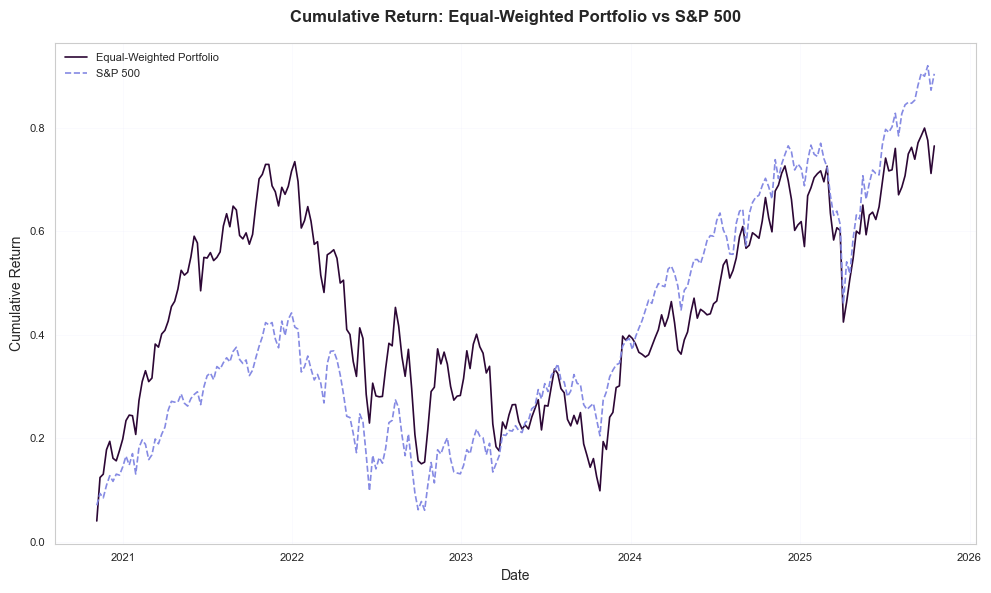

In [18]:
# Compute cumulative return series (using log returns)
data['Cumulative_Portfolio'] = (1 + data['Portfolio_ret']).cumprod() - 1
data['Cumulative_SP500']     = (1 + data['SP500_ret']).cumprod() - 1

# Custom color palette (from your image)
colors = {
    'portfolio': '#2C0735',   # medium violet
    'sp500': '#858AE3',       # light aqua
    'grid': '#E6E6FA'         # faint lavender gridlines
}

plt.figure(figsize=(10, 6))

plt.plot(
    data['Date'], data['Cumulative_Portfolio'],
    label='Equal-Weighted Portfolio',
    color=colors['portfolio'],
    linewidth=1.2
)

plt.plot(
    data['Date'], data['Cumulative_SP500'],
    label='S&P 500',
    color=colors['sp500'],
    linewidth=1.2,
    linestyle='--'
)

# Styling and aesthetics
plt.title('Cumulative Return: Equal-Weighted Portfolio vs S&P 500',
          fontsize=12, pad=15, fontweight='semibold')
plt.xlabel('Date', fontsize=10)
plt.ylabel('Cumulative Return', fontsize=10)
plt.grid(alpha=0.3, color=colors['grid'])
plt.legend(frameon=False)
plt.tight_layout()

# Save chart for report
plt.savefig("./output/portfolio_vs_sp500_custom.png", dpi=300, bbox_inches='tight')
plt.show()


Step 4F – Export Results to Excel

In [19]:
# --- 1. Performance metrics table (from Step 4D) ---
summary_table = pd.DataFrame({
    'Metric': ['Mean Weekly Return', 'Weekly Std Dev', 'Sharpe Ratio',
               'Annualized Return', 'Annualized Std Dev', 'Annualized Sharpe'],
    'Portfolio': [mean_port, std_port, sharpe_port,
                  mean_port*52, std_port*np.sqrt(52), sharpe_port*np.sqrt(52)],
    'S&P500': [mean_mkt, std_mkt, sharpe_mkt,
               mean_mkt*52, std_mkt*np.sqrt(52), sharpe_mkt*np.sqrt(52)]
})

# --- 2. Final cumulative-return snapshot ---
latest_row = data.iloc[-1][['Date', 'Cumulative_Portfolio', 'Cumulative_SP500']]
snapshot = pd.DataFrame({
    'Date': [latest_row['Date'].date()],
    'Portfolio_Cumulative': [latest_row['Cumulative_Portfolio']],
    'SP500_Cumulative': [latest_row['Cumulative_SP500']]
})

# --- 3. Export to Excel with two sheets ---
output_file = "./output/step4_portfolio_equal.xlsx"
with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
    summary_table.to_excel(writer, sheet_name='Performance_Metrics', index=False)
    snapshot.to_excel(writer, sheet_name='Cumulative_Snapshot', index=False)

print(f"\n✅ Exported results to {output_file}")
print("\n--- Cumulative Snapshot ---")
print(snapshot)


✅ Exported results to ./output/step4_portfolio_equal.xlsx

--- Cumulative Snapshot ---
         Date  Portfolio_Cumulative  SP500_Cumulative
0  2025-10-17              0.764436          0.903658


### 5. Optimal Portfolio Analysis Construction & Performance Analysis

Step 5A – Load and Prepare Data

In [20]:
# --- 1. Load datasets ---
returns = pd.read_csv("./output/step1_returns.csv", index_col=0, parse_dates=True)
rf_data = pd.read_csv("./data/13w_tbill.csv", parse_dates=['Date'], date_format="%m/%d/%y")

# --- 2. Inspect ---
print("Return data shape:", returns.shape)
print("Risk-free data shape:", rf_data.shape)
print("\nSample returns head:")
print(returns.head())

# --- 3. Convert T-bill yield (annualized %) to weekly decimal rate ---
rf_weekly = (rf_data['Close'] / 100) / 52
rf_mean = rf_weekly.mean()
print(f"\nAverage weekly risk-free rate: {rf_mean:.6f}")

# --- 4. Compute mean returns and covariance matrix ---
mean_returns = returns.mean()     # μ vector
cov_matrix = returns.cov()        # Σ matrix

print("\nMean Weekly Returns (μ):")
print(mean_returns.round(5))

print("\nCovariance Matrix (Σ):")
print(cov_matrix.round(6).iloc[:5, :5])  # preview

# --- 5. Export optional intermediate results ---
mean_returns.to_csv("./output/step5_mean_returns.csv")
cov_matrix.to_csv("./output/step5_cov_matrix.csv")

# --- Outputs for optimization ---
mu = mean_returns.values
Sigma = cov_matrix.values
rf = rf_mean
tickers = mean_returns.index.tolist()

print("\nData ready for Step 5B optimization.")

Return data shape: (260, 10)
Risk-free data shape: (1256, 6)

Sample returns head:
                 JPM       BAC       WFC        GS       BLK       PLD  \
Date                                                                     
2020-10-30 -0.057187 -0.049393 -0.081870 -0.081246 -0.061644 -0.039918   
2020-11-06  0.048965  0.025413  0.021219  0.062639  0.088870  0.055774   
2020-11-13  0.102559  0.104949  0.094023  0.084839  0.022452 -0.013051   
2020-11-20  0.004286 -0.007062  0.056928  0.019303  0.004380 -0.031995   
2020-11-27  0.056421  0.078176  0.110606  0.052546  0.061122  0.003286   

                 AMT       SPG       AVB         O  
Date                                                
2020-10-30 -0.034537 -0.062786 -0.046758 -0.048740  
2020-11-06  0.053001 -0.015241  0.061466  0.002243  
2020-11-13  0.003874  0.188606  0.135034  0.083658  
2020-11-20 -0.043854  0.082449  0.015004 -0.043105  
2020-11-27  0.006127  0.053171 -0.023723  0.020488  

Average weekly risk-free r

Step 5B – Optimization Setup & Computation of Optimal Weights

In [21]:
# --- Objective: negative Sharpe ratio (since we minimize) ---
def neg_sharpe_ratio(weights, mu, Sigma, rf):
    portfolio_return = np.dot(weights, mu)
    portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(Sigma, weights)))
    sharpe = (portfolio_return - rf) / portfolio_vol
    return -sharpe  # minimize negative Sharpe

# --- Constraints & bounds ---
n = len(mu)
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})   # sum of weights = 1
bounds = tuple((0, 1) for _ in range(n))                         # long-only

# --- Initial guess (equal weights) ---
init_guess = np.repeat(1/n, n)

# --- Optimization ---
opt_result = minimize(
    neg_sharpe_ratio,
    init_guess,
    args=(mu, Sigma, rf),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# --- Extract optimal weights ---
opt_weights = opt_result.x
opt_sharpe = -opt_result.fun

# --- Compute portfolio stats ---
opt_return = np.dot(opt_weights, mu)
opt_vol = np.sqrt(np.dot(opt_weights.T, np.dot(Sigma, opt_weights)))

# --- Display results ---
opt_summary = pd.DataFrame({
    'Ticker': tickers,
    'Optimal_Weight': opt_weights
}).sort_values('Optimal_Weight', ascending=False)

print("\n--- Optimal Portfolio Weights ---")
print(opt_summary.round(4))

print("\n--- Optimal Portfolio Metrics ---")
print(f"Expected Weekly Return:  {opt_return:.5f}")
print(f"Weekly Volatility:       {opt_vol:.5f}")
print(f"Sharpe Ratio:            {opt_sharpe:.4f}")



--- Optimal Portfolio Weights ---
  Ticker  Optimal_Weight
3     GS          0.6563
2    WFC          0.2330
7    SPG          0.1060
0    JPM          0.0048
1    BAC          0.0000
9      O          0.0000
5    PLD          0.0000
4    BLK          0.0000
8    AVB          0.0000
6    AMT          0.0000

--- Optimal Portfolio Metrics ---
Expected Weekly Return:  0.00484
Weekly Volatility:       0.03834
Sharpe Ratio:            0.1108


Step 5C – Portfolio Evaluation & Comparison

In [22]:
# --- 1. Load equal-weighted results from Step 4 (if available) ---
eq_metrics = None
try:
    eq_df = pd.read_excel("./output/step4_portfolio_equal.xlsx", sheet_name=0)
    print("Equal-weighted portfolio metrics loaded.")
    print(eq_df.head())
    eq_metrics = eq_df.set_index("Metric").loc[
        ["Mean Weekly Return", "Weekly Std Dev", "Sharpe Ratio"], "Portfolio"
    ].astype(float)
except Exception as e:
    print("⚠️ Could not load equal-weighted results. Please verify file path or sheet.")
    print(e)

# --- 2. Compute S&P500 weekly metrics (optional) ---
try:
    sp500 = pd.read_csv("./data/sp500.csv", index_col="Date", parse_dates=["Date"], date_format="%m/%d/%y")
    sp500_ret = sp500["Close"].pct_change().dropna()
    sp500_mean = sp500_ret.mean()
    sp500_vol = sp500_ret.std()
    sp500_sharpe = (sp500_mean - rf) / sp500_vol
    print("\nS&P500 metrics calculated.")
except Exception as e:
    print("⚠️ S&P500 data not available or column mismatch.")
    sp500_mean = sp500_vol = sp500_sharpe = np.nan

# --- 3. Create comparison table ---
comparison = pd.DataFrame({
    "Metric": ["Mean Weekly Return", "Weekly Std Dev", "Sharpe Ratio"],
    "Optimal Portfolio": [opt_return, opt_vol, opt_sharpe],
    "Equal-weighted": eq_metrics.values if eq_metrics is not None else [np.nan]*3,
    "S&P500": [sp500_mean, sp500_vol, sp500_sharpe]
}).set_index("Metric")

print("\n--- Portfolio Comparison ---")
print(comparison.round(5))

# --- 4. Export to Excel (accumulating for Step 5E) ---
with pd.ExcelWriter("./output/step5_portfolio_optimal.xlsx", engine="openpyxl", mode="w") as writer:
    opt_summary.to_excel(writer, sheet_name="Optimal Weights", index=False)
    comparison.to_excel(writer, sheet_name="Comparison Metrics")

print("\n✅ Comparison metrics saved to ./output/step5_portfolio_optimal.xlsx")

Equal-weighted portfolio metrics loaded.
               Metric  Portfolio    S&P500
0  Mean Weekly Return   0.002592  0.002749
1      Weekly Std Dev   0.028180  0.022837
2        Sharpe Ratio   0.071335  0.094905
3   Annualized Return   0.134770  0.142938
4  Annualized Std Dev   0.203212  0.164681

S&P500 metrics calculated.

--- Portfolio Comparison ---
                    Optimal Portfolio  Equal-weighted   S&P500
Metric                                                        
Mean Weekly Return            0.00484         0.00259  0.00060
Weekly Std Dev                0.03834         0.02818  0.01076
Sharpe Ratio                  0.11078         0.07134  0.00130

✅ Comparison metrics saved to ./output/step5_portfolio_optimal.xlsx


Step 5D – Efficient-Frontier Visualization & Export

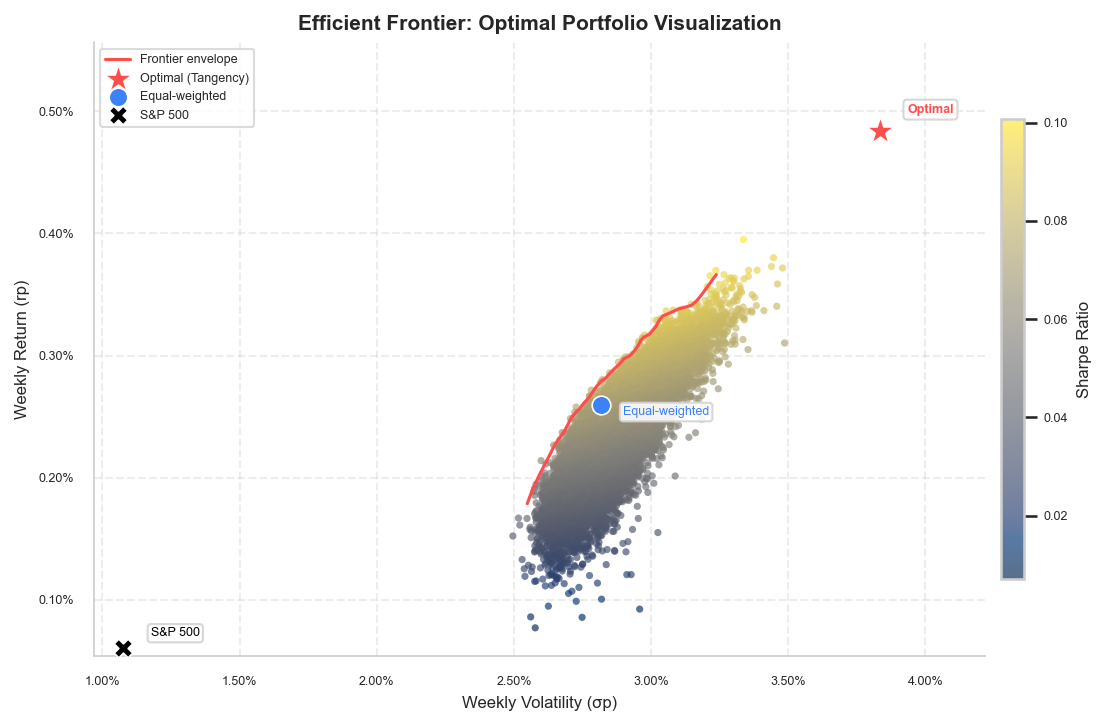


✅ Efficient Frontier plotted and saved as './output/step5_efficient_frontier.png'
✅ Frontier data appended to './output/step5_portfolio_optimal.xlsx'


In [23]:
# --- 1. Simulate random portfolios to approximate the efficient frontier ---
n_portfolios = 20000
n_assets = len(mu)

np.random.seed(42)
port_returns, port_vols, port_sharpes = [], [], []

for _ in range(n_portfolios):
    w = np.random.random(n_assets)
    w /= np.sum(w)
    r = np.dot(w, mu)
    s = np.sqrt(np.dot(w.T, np.dot(Sigma, w)))
    port_returns.append(r)
    port_vols.append(s)
    port_sharpes.append((r - rf) / s)

frontier_df = pd.DataFrame({
    'Return': port_returns,
    'Volatility': port_vols,
    'Sharpe': port_sharpes
})

# --- 2. Prepare special points ---
eq_return = comparison.loc["Mean Weekly Return", "Equal-weighted"]
eq_vol = comparison.loc["Weekly Std Dev", "Equal-weighted"]
eq_sharpe = comparison.loc["Sharpe Ratio", "Equal-weighted"]

opt_point = (opt_vol, opt_return)
eq_point = (eq_vol, eq_return)
sp500_point = (
    comparison.loc["Weekly Std Dev", "S&P500"],
    comparison.loc["Mean Weekly Return", "S&P500"]
)

# --- 3. Efficient Frontier Plot ---
plt.rcParams.update({'font.family':'DejaVu Sans'})

sns.set_theme(style="whitegrid", context="notebook", rc={"figure.dpi":150})

colors = {
    'portfolio': '#2C0735',
    'sp500': '#858AE3',
    'grid': '#E6E6FA'
}

fig, ax = plt.subplots(figsize=(8,5), facecolor='white')

# cloud of simulated portfolios — use valid edgecolor and rasterize for many points
sc = ax.scatter(
    frontier_df['Volatility'],
    frontier_df['Return'],
    c=frontier_df['Sharpe'],
    cmap='cividis',
    s=12,
    alpha=0.65,
    edgecolors='none',
    rasterized=True,
    zorder=2
)

# compute a simple upper-envelope (approximate efficient frontier)
df_sorted = frontier_df.sort_values('Volatility').reset_index(drop=True)
df_sorted['cummax_return'] = df_sorted['Return'].cummax()
envelope = df_sorted[df_sorted['Return'] == df_sorted['cummax_return']]
envelope = envelope.rolling(5, center=True).mean().dropna()  # <-- new smoothing line
ax.plot(envelope['Volatility'], envelope['Return'],
        color='#FF4D4D', lw=1.5, label='Frontier envelope', zorder=4)

# highlight key portfolios
ax.scatter(opt_vol, opt_return, color='#FF4D4D', marker='*', s=200,
           edgecolor='white', linewidth=0.8, zorder=6, label='Optimal (Tangency)')
ax.scatter(eq_vol, eq_return, color='#3B82F6', marker='o', s=80,
           edgecolor='white', linewidth=0.8, zorder=5, label='Equal-weighted')
ax.scatter(sp500_point[0], sp500_point[1], color='black', marker='X', s=80,
           edgecolor='white', linewidth=0.8, zorder=5, label='S&P 500')

# annotations with boxed background
ax.annotate('Optimal', xy=(opt_vol, opt_return), xytext=(opt_vol+0.001, opt_return+0.00015),
            fontsize=6, fontweight='semibold', color='#FF4D4D',
            bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='lightgray', alpha=0.9))

ax.annotate('Equal-weighted', xy=(eq_vol, eq_return), xytext=(eq_vol+0.0008, eq_return-0.00008),
            fontsize=6, color='#3B82F6',
            bbox=dict(boxstyle='round,pad=0.25', fc='white', ec='lightgray', alpha=0.9))

ax.annotate('S&P 500', xy=(sp500_point[0], sp500_point[1]), xytext=(sp500_point[0]+0.001, sp500_point[1]+0.0001),
            fontsize=6, color='black',
            bbox=dict(boxstyle='round,pad=0.25', fc='white', ec='lightgray', alpha=0.9))

# colorbar formatting (as percent)
cbar = plt.colorbar(sc, ax=ax, pad=0.015, shrink=0.75)
cbar.set_label('Sharpe Ratio', fontsize=8)
cbar.ax.tick_params(labelsize=6)

# axis formatting as percentages
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=2))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=2))

# widen the view window to include S&P500 and Optimal
x_min = min(frontier_df['Volatility'].min(), sp500_point[0]) * 0.9
x_max = max(frontier_df['Volatility'].max(), opt_point[0]) * 1.1
y_min = min(frontier_df['Return'].min(), sp500_point[1]) * 0.9
y_max = max(frontier_df['Return'].max(), opt_point[1]) * 1.15

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)


ax.set_xlabel("Weekly Volatility (σp)", fontsize=8)
ax.set_ylabel("Weekly Return (rp)", fontsize=8)
ax.set_title("Efficient Frontier: Optimal Portfolio Visualization", fontsize=10, weight='bold')

# spines and ticks
for spine in ['top','right']:
    ax.spines[spine].set_visible(False)
for spine in ['left','bottom']:
    ax.spines[spine].set_linewidth(0.8)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.minorticks_on()
ax.grid(True, which='major', linestyle='--', alpha=0.35)

ax.legend(
    frameon=True,
    fontsize=6,
    loc='upper left',
    facecolor='white',
    edgecolor='lightgray'
)

plt.tight_layout()
plt.savefig("./output/step5_efficient_frontier_pretty.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
# ...existing code...

with pd.ExcelWriter("./output/step5_portfolio_optimal.xlsx", engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    frontier_df.to_excel(writer, sheet_name="Efficient Frontier", index=False)

print("\n✅ Efficient Frontier plotted and saved as './output/step5_efficient_frontier.png'")
print("✅ Frontier data appended to './output/step5_portfolio_optimal.xlsx'")